In [1]:
%load_ext autoreload
%autoreload 2

import json
import os
import pickle
import warnings
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy
import torch
import wandb
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})
rng = np.random.default_rng(42)
run_files = {
    'UNC_MEA': 'uncertainty_measures.pkl', 
    'VAL_GEN': 'validation_generations.pkl', # essential for SEP training
    'WAN_SUM': 'wandb-summary.json'
}

from helper_functions import *

In [3]:
model_name = 'Llama2-7b'

cwd = '/Users/xy/Github/semantic-entropy-probes/semantic_entropy_probes'

ds_paths_rel = ['llama2-7b-chat_trivia-qa/offline-run-20241128']
# ds_paths_rel = ['llama2-7b-chat_trivia-qa/offline-run-20241127']

ds_paths = [os.path.join(cwd, path) for path in ds_paths_rel]
print('ds_paths:', ds_paths)

ds_names = ['trivia-qa']

ds_paths: ['/Users/xy/Github/semantic-entropy-probes/semantic_entropy_probes/llama2-7b-chat_trivia-qa/offline-run-20241128']


In [4]:
# Create Dataset class for easier attribute keeping
class Dataset:
    def __init__(self, values):
        self.tbg_dataset = values[0]
        self.slt_dataset = values[1]
        self.entropy = values[2]
        self.accuracies = values[3]

def load_dataset(path, n_sample=2000):
    os.chdir(path)
    
    # Read validation generated embeddings
    with open(run_files['VAL_GEN'], 'rb') as f:
        generations = pickle.load(f)
    
    # Read uncertainty measures (p-true, predictive/semantic uncertainties)
    with open(run_files['UNC_MEA'], 'rb') as g:
        measures = pickle.load(g)

    # Attribute names are hardcoded into the files
    entropy = torch.tensor(measures['uncertainty_measures']['cluster_assignment_entropy']).to(torch.float32)
    
    accuracies = torch.tensor([record['most_likely_answer']['accuracy'] for record in generations.values()])
    
    # hidden states for TBG (token before model generation) 
    tbg_dataset = torch.stack([record['most_likely_answer']['emb_last_tok_before_gen'] 
                               for record in generations.values()]).squeeze(-2).transpose(0, 1).to(torch.float32)
    
    # hidden states for SLT (second last token of model generation)
    slt_dataset = torch.stack([record['most_likely_answer']['emb_tok_before_eos'] 
                               for record in generations.values()]).squeeze(-2).transpose(0, 1).to(torch.float32)

    return (tbg_dataset[:, :n_sample, :], slt_dataset[:, :n_sample, :], entropy[:n_sample], accuracies[:n_sample])

In [5]:
# Load all datasets
Ds = []
for path in ds_paths:
    Ds.append(Dataset(load_dataset(path)))

# Set essential attributes for prettier printing
for i, D in enumerate(Ds):
    D.name = ds_names[i]
    D.path = ds_paths[i]
    # OOD-related
    D.other_ids = [j for j in range(len(Ds)) if j != i]
    D.other_names = [ds_names[j] for j in D.other_ids]

### Binarize Semantic Entropy (SE)

Dummy accuracy for trivia-qa: 0.7300


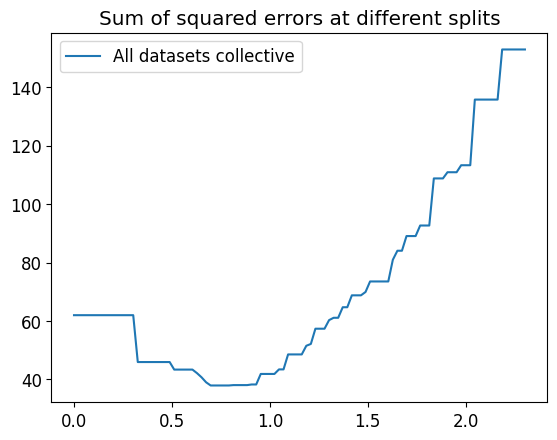

In [6]:
# Best universal split across datasets
split_method = 'best-universal-split'
all_entropy = torch.cat([D.entropy for D in Ds], dim=0)
split = best_split(all_entropy, "All datasets collective")
plt.legend()
plt.title('Sum of squared errors at different splits')
for D in Ds:
    D.b_entropy = binarize_entropy(D.entropy, split)
    print(f"Dummy accuracy for {D.name}: {max(torch.mean(D.b_entropy).item(), 1-torch.mean(D.b_entropy).item()):.4f}")

### Train linear probes to predict Binarized SE

In [7]:
def train_single_metric(D, token_type='tbg', metric='b_entropy'):
    """train and test on single metric (e.g. SE, Acc) on single dataset"""
    var_name = token_type[0] + metric[0] 
    # named as [te, se. ta, sa] for easy identification; t for tbg, s for slt (token positions)
    # e for entropy and a for accuracy (or model faithfulness)
    X_trains, X_vals, X_tests, y_trains, y_vals, y_tests = create_Xs_and_ys(
        getattr(D, f'{token_type}_dataset'), getattr(D, metric)
    )

    accs = []
    aucs = []
    models = []
    
    for i, (X_train, X_val, X_test, y_train, y_val, y_test) in enumerate(zip(X_trains, X_vals, X_tests, y_trains, y_vals, y_tests)):
        print(f"Training on {D.name}-{token_type.upper()}-{metric.upper()} {i+1}/{len(X_trains)}")
        # model = LogisticRegression()
        model = SVC(kernel='linear', probability=True)
        sklearn_train_and_evaluate(model, X_train, y_train, X_val, y_val)
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test, y_test)
        accs.append(test_acc)
        aucs.append(test_auc)
        models.append(model)

    setattr(D, f'{var_name}_accs', accs)
    setattr(D, f'{var_name}_aucs', aucs)
    setattr(D, f'{var_name}_models', models)

In [8]:
for D in Ds:
    train_single_metric(D, 'tbg', 'b_entropy')
    train_single_metric(D, 'slt', 'b_entropy')

Training on trivia-qa-TBG-B_ENTROPY 1/33
Validation Accuracy: 0.5972, AUROC: 0.5718
Training Loss: 0.3797, Validation Loss: 0.7358
Test Loss: 0.5448, Test Accuracy: 0.7500, AUROC: 0.6400
Training on trivia-qa-TBG-B_ENTROPY 2/33
Validation Accuracy: 0.5972, AUROC: 0.5830
Training Loss: 0.3940, Validation Loss: 0.7454
Test Loss: 0.5522, Test Accuracy: 0.7000, AUROC: 0.6200
Training on trivia-qa-TBG-B_ENTROPY 3/33
Validation Accuracy: 0.6667, AUROC: 0.7217
Training Loss: 0.4005, Validation Loss: 0.7067
Test Loss: 0.5872, Test Accuracy: 0.6000, AUROC: 0.4433
Training on trivia-qa-TBG-B_ENTROPY 4/33
Validation Accuracy: 0.6667, AUROC: 0.7025
Training Loss: 0.3837, Validation Loss: 0.6909
Test Loss: 0.5667, Test Accuracy: 0.7000, AUROC: 0.5433
Training on trivia-qa-TBG-B_ENTROPY 5/33
Validation Accuracy: 0.6667, AUROC: 0.6800
Training Loss: 0.3617, Validation Loss: 0.6847
Test Loss: 0.5546, Test Accuracy: 0.7500, AUROC: 0.5500
Training on trivia-qa-TBG-B_ENTROPY 6/33
Validation Accuracy: 0.6

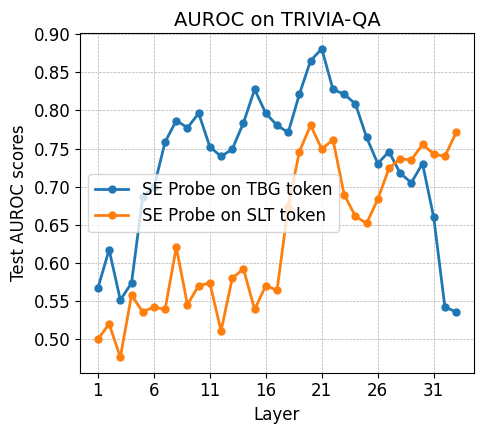

In [14]:
# plot se probe
fig, axs = plt.subplots(1, len(Ds), figsize=(5 * len(Ds), 4.5))

if len(Ds) == 1:
    axs = [axs]

for i, D in enumerate(Ds):
    plot_metrics_ax(axs[i], [auc(D.tb_aucs), auc(D.sb_aucs)], ["SE Probe on TBG token", "SE Probe on SLT token"], 
                    f"AUROC on {D.name.upper()}", prep_func=idf)
plt.tight_layout()
save_fig(name="se_both_tok_svm")
plt.show()

In [9]:
print(vars(Ds[0]).keys())
print(len(Ds[0].sb_models))

dict_keys(['tbg_dataset', 'slt_dataset', 'entropy', 'accuracies', 'name', 'path', 'other_ids', 'other_names', 'b_entropy', 'tb_accs', 'tb_aucs', 'tb_models', 'sb_accs', 'sb_aucs', 'sb_models'])
33


In [10]:
tb_model = Ds[0].tb_models[20]
print('# of SVs:', len(tb_model.support_))
print('indices of SV:')
print(tb_model.support_)

# of SVs: 216
indices of SV:
[  0   3   7  12  13  17  18  21  23  24  27  29  30  32  33  34  38  40
  42  43  44  46  49  50  51  52  53  58  59  60  61  62  66  67  68  70
  71  73  75  78  79  80  81  82  83  90  93  96  97  99 101 103 104 107
 108 110 112 114 116 117 118 121 122 124 126 127 131 132 134 136 137 139
 140 142 144 145 146 147 148 153 155 156 158 160 162 163 166 168 169 170
 173 176 177 180 181 182 184 185 186 187 190 192 194 195 196 202 204 207
 208 209 211 212 213 214 216 217 221 223 224 226 227 229 234 240 241 243
 245 246 248 250 252 253 254 255 256 259 261 262 264 265 272 273 276 277
 278 279 280 282 284 287   1   4   6   9  10  15  16  22  25  28  35  37
  41  48  54  56  64  74  84  85  86  89  92  94 102 109 113 119 120 123
 138 143 149 151 152 161 167 172 174 188 189 193 198 199 203 206 215 218
 220 228 232 239 244 249 251 260 263 266 267 268 269 271 274 281 283 285]


In [11]:
print(Ds[0].tbg_dataset.shape)

torch.Size([33, 400, 4096])


In [12]:
exp_details = pickle.load(open('experiment_details.pkl', 'rb'))

In [13]:
print(len(exp_details))
print(exp_details.keys())
print(exp_details['validation']['indices'])
print('# of validation indices:', len(exp_details['validation']['indices']))

9
dict_keys(['args', 'prompt_indices', 'prompt', 'BRIEF', 'p_true_indices', 'p_true_responses', 'p_true_few_shot_prompt', 'train', 'validation'])
[2102, 2628, 2854, 1605, 386, 1624, 484, 962, 437, 1731, 2956, 2616, 1273, 2962, 1187, 2185, 2660, 405, 1415, 2137, 2538, 1946, 2489, 1001, 2181, 1190, 50, 2724, 647, 2773, 1582, 2840, 937, 396, 2090, 2609, 1942, 408, 2363, 1634, 2387, 892, 1176, 1455, 285, 772, 2549, 2286, 2175, 106, 306, 1639, 128, 70, 2675, 1763, 1386, 729, 2977, 194, 1468, 1328, 2561, 1950, 700, 77, 842, 521, 1184, 825, 1011, 1009, 3043, 2517, 2232, 2394, 2439, 1715, 2257, 127, 513, 22, 504, 113, 225, 2808, 728, 510, 2839, 1578, 276, 59, 2711, 1777, 2710, 748, 2556, 1727, 195, 2259, 694, 216, 2878, 1541, 2368, 1880, 1864, 1375, 760, 141, 1633, 2570, 1883, 2002, 2905, 2920, 1493, 2727, 288, 569, 1086, 1037, 721, 373, 1887, 54, 629, 1138, 321, 2149, 1263, 576, 428, 2199, 493, 1178, 2889, 2532, 1370, 14, 2358, 1063, 2601, 2119, 1751, 2087, 597, 2958, 243, 2596, 231, 2493, 24

In [48]:
print(exp_details['prompt_indices'])
print(exp_details['p_true_indices'])

[9361, 533, 7026, 7906, 9471]
[243, 3376, 7578, 8049, 4546, 10706, 2625, 563, 8530, 8029, 5370, 1246, 4095, 12215, 5917, 730, 6887, 2272, 9882, 5817]


In [14]:
val_gens = pickle.load(open('validation_generations.pkl', 'rb'))
print(len(val_gens))
print(type(val_gens))
print(val_gens.keys())

400
<class 'dict'>
dict_keys(['sfq_1377--91/91_1497797.txt#0_1', 'wh_4269--173/173_235742.txt#0_0', 'sfq_15401--88/88_1813633.txt#0_1', 'sfq_3917--169/169_1555303.txt#0_0', 'wh_2414--73/73_48566.txt#0_0', 'sfq_11783--191/191_1732943.txt#0_1', 'qg_2887--Lacrosse.txt#0_0', 'sfq_16267--E._L._James.txt#0_2', 'jp_2940--195/195_1424532.txt#0_1', 'qb_5499--156/156_419027.txt#0_0', 'sfq_9644--123/123_186355.txt#0_2', 'qb_637--10/10_282457.txt#0_0', 'qw_11443--84/84_2975478.txt#0_0', 'jp_742--32/32_1368333.txt#0_2', 'wh_3212--72/72_800524.txt#0_2', 'qb_1502--134/134_2618044.txt#0_0', 'qb_2774--81/81_303935.txt#0_0', 'bb_1997--80/80_876537.txt#0_1', 'bt_1811--193/193_2452704.txt#0_1', 'sfq_5662--54/54_415167.txt#0_2', 'odql_4122--97/97_2155160.txt#0_1', 'sfq_16378--17/17_461209.txt#0_0', 'qz_4241--129/129_203139.txt#0_0', 'sfq_9677--35/35_1731921.txt#0_0', 'sfq_11145--8/8_2764204.txt#0_0', 'sfq_13406--148/148_983957.txt#0_0', 'sfq_2528--156/156_1523996.txt#0_1', 'qf_2575--20/20_3214656.txt#0_0',

In [15]:
samp_key = list(val_gens.keys())[0]
print(samp_key)
print(val_gens[samp_key].keys())
print(len(val_gens[samp_key]['responses']))
print(val_gens[samp_key]['responses'][0])

print('reference', val_gens[samp_key]['reference'])
print('most_likely_answer.keys():', val_gens[samp_key]['most_likely_answer'].keys())
print('most_likely_answer.accuracy:', val_gens[samp_key]['most_likely_answer']['accuracy'])

sfq_1377--91/91_1497797.txt#0_1
dict_keys(['question', 'context', 'most_likely_answer', 'reference', 'responses'])
10
('yarrow', [array(-0.39165074, dtype=float32), array(0., dtype=float32)], tensor([[ 3.4293,  0.1238,  1.2401,  ..., -2.8851, -2.2979,  1.8054]]), 0.0)
reference {'answers': {'answer_start': [965], 'text': ['achillea millefolium']}, 'id': 'sfq_1377--91/91_1497797.txt#0_1'}
most_likely_answer.keys(): dict_keys(['response', 'token_log_likelihoods', 'embedding', 'accuracy', 'emb_last_tok_before_gen', 'emb_tok_before_eos'])
most_likely_answer.accuracy: 0.0


In [17]:
# all accs of most likely answers in val_gens
all_accs = [val_gens[k]['most_likely_answer']['accuracy'] for k in val_gens.keys()]
print(len(all_accs))
print('mean acc:', np.mean(all_accs))

400
mean acc: 0.605


In [19]:
# Compare the accs of SVs vs. non-SVs in tb_model

sv_accs = [val_gens[k]['most_likely_answer']['accuracy'] for i, k in enumerate(val_gens.keys()) if i in tb_model.support_]
print(f'{len(sv_accs)} SVs: mean={np.mean(sv_accs)}, sd={np.std(sv_accs)}')

non_sv_accs = [val_gens[k]['most_likely_answer']['accuracy'] for i, k in enumerate(val_gens.keys()) if i not in tb_model.support_]
print(f'{len(non_sv_accs)} non-SVs: mean={np.mean(non_sv_accs)}, sd={np.std(non_sv_accs)}')

216 SVs: mean=0.6157407407407407, sd=0.48641965516700153
184 non-SVs: mean=0.592391304347826, sd=0.4913897097832915


In [21]:
all_toklogliks = [val_gens[k]['most_likely_answer']['token_log_likelihoods'] for i, k in enumerate(val_gens.keys())]
print(len(all_toklogliks))
print(all_toklogliks[:3])
# print('mean tokloglike:', np.mean(all_toklogliks))
# print('sd tokloglike:', np.std(all_toklogliks))

400
[[array(0., dtype=float32), array(0., dtype=float32)], [array(0., dtype=float32), array(0., dtype=float32)], [array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32)]]
